In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.6 MB/s eta 0:00:00


In [2]:

import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error, log_loss
from scipy.optimize import minimize_scalar


# 0. Configuration

In [3]:
TRAIN_PATH = "/content/train.csv"
TEST_PATH  = "/content/test.csv"
ID_COL = "id"
TARGET = "spending_30d"
N_FOLDS = 5
SEED = 42
OPTUNA_TRIALS = 100  # Set to 50 or 100 for better results!

# Check for GPU
try:
    import subprocess
    nvidia_smi = subprocess.check_output('nvidia-smi', shell=True)
    DEVICE = 'cuda'
    print("GPU Detected: Accelerating XGBoost with CUDA")
except:
    DEVICE = 'cpu'
    print("No GPU detected. Running on CPU (will be slower).")

GPU Detected: Accelerating XGBoost with CUDA


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

print(f"Training data loaded with shape: {df_train.shape}")
print(f"Test data loaded with shape: {df_test.shape}")

Training data loaded with shape: (104000, 35)
Test data loaded with shape: (25889, 34)


## Perform Missing Value Check

### Subtask:
Calculate and display the number and percentage of missing values for each column in the loaded training DataFrame.


**Reasoning**:
I will calculate the number and percentage of missing values for each column in the `df_train` DataFrame, create a summary DataFrame, and display it sorted by the percentage of missing values in descending order to fulfill the subtask.



In [5]:
missing_values = df_train.isnull().sum()
missing_percentage = (df_train.isnull().sum() / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)

print("Missing values in df_train:")
print(missing_df[missing_df['Missing Count'] > 0])

Missing values in df_train:
                             Missing Count  Missing Percentage
primary_game                          6168            5.930769
sessions_per_week                     6162            5.925000
days_since_last_purchase              6148            5.911538
total_transactions                    6133            5.897115
total_playtime_hours                  6132            5.896154
payment_methods_used                  6108            5.873077
daily_login_streak                    6107            5.872115
social_interactions                   6106            5.871154
account_age_days                      6102            5.867308
historical_spending                   6099            5.864423
platform                              6095            5.860577
vip_status                            6094            5.859615
cross_game_activity                   6083            5.849038
owns_limited_edition                  6075            5.841346
segment                    

## Plot Target Variable Histogram




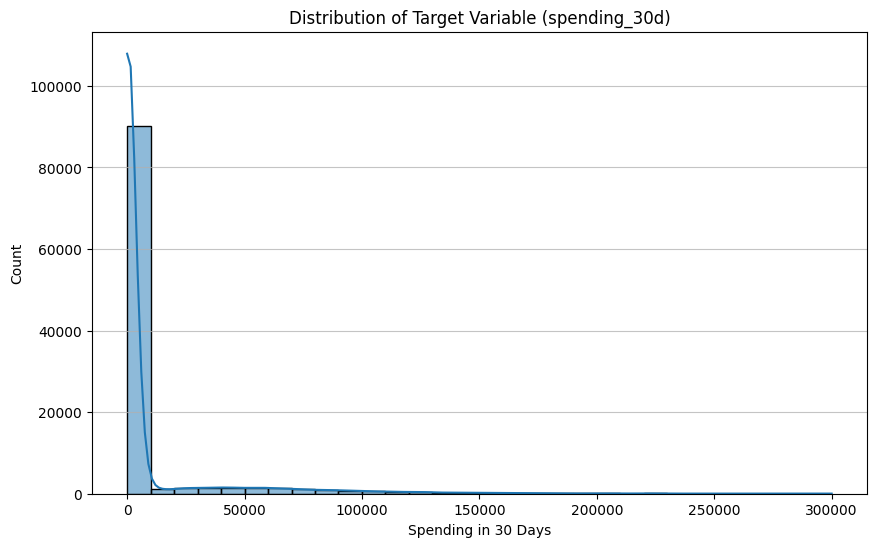

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['spending_30d'], bins=30, kde=True)
plt.title('Distribution of Target Variable (spending_30d)')
plt.xlabel('Spending in 30 Days')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Task
Calculate the proportion of entries in the training dataset where `spending_30d` is zero versus non-zero, then visualize this distribution using a pie chart or bar chart. Additionally, create a histogram showing the distribution of `spending_30d` for only the non-zero cases.

## Analyze and Plot Spend vs. No Spend

### Subtask:
Calculate the proportion of entries with zero spending (`spending_30d == 0`) versus non-zero spending (`spending_30d > 0`) in the training dataset. Visualize this distribution using a pie chart or bar chart, and then create a histogram to show the distribution of spending specifically for the non-zero cases.


**Reasoning**:
First, I will calculate the number of entries with zero and non-zero spending, store these counts in a Series, and then display the counts to understand the distribution.



In [7]:
zero_spending = (df_train['spending_30d'] == 0).sum()
non_zero_spending = (df_train['spending_30d'] > 0).sum()

spending_distribution = pd.Series({
    'Zero Spending': zero_spending,
    'Non-Zero Spending': non_zero_spending
})

print("Spending Distribution:")
print(spending_distribution)

Spending Distribution:
Zero Spending        50132
Non-Zero Spending    53868
dtype: int64


# Task
* **Visualize Zero vs. Non-Zero Spending**: Create a pie chart to visualize the proportion of entries with zero spending versus non-zero spending, using the previously calculated `spending_distribution`.
* **Plot Non-Zero Spending Distribution**: Create a histogram showing the distribution of `spending_30d` for only the cases where `spending_30d` is greater than 0.
* **Final Task**: Summarize the insights gained from the visualizations of spending distribution.

## Visualize Zero vs. Non-Zero Spending

### Subtask:
Create a pie chart to visualize the proportion of entries with zero spending versus non-zero spending, using the previously calculated `spending_distribution`.


**Reasoning**:
I will create a pie chart to visualize the proportion of zero vs. non-zero spending, as requested by the subtask, using the `spending_distribution` Series that was previously calculated.



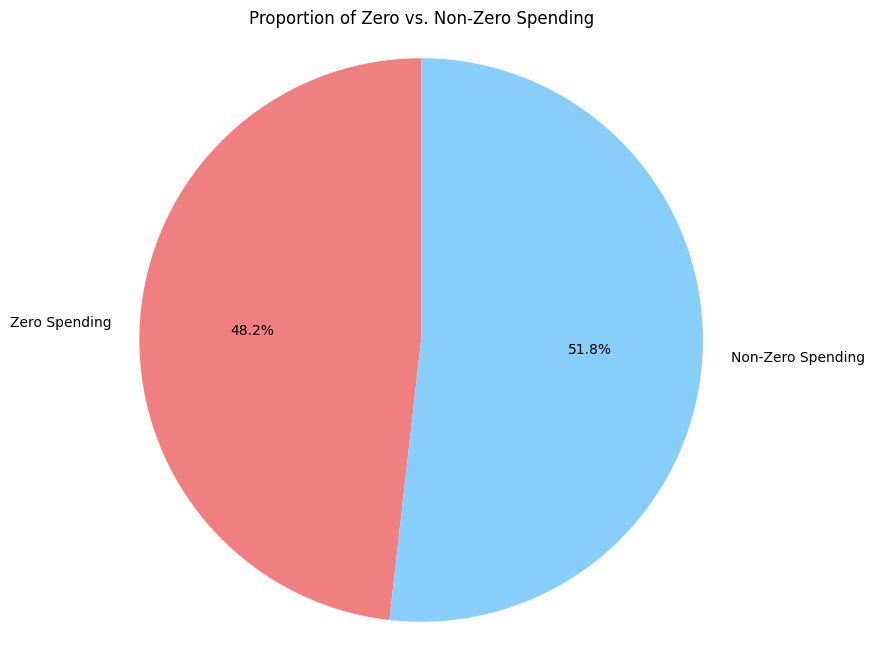

In [8]:
plt.figure(figsize=(8, 8))
plt.pie(spending_distribution, labels=spending_distribution.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Proportion of Zero vs. Non-Zero Spending')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Reasoning**:
Now that the pie chart for zero vs. non-zero spending is done, I will create a histogram to visualize the distribution of `spending_30d` specifically for cases where the spending is greater than zero, as requested by the task.



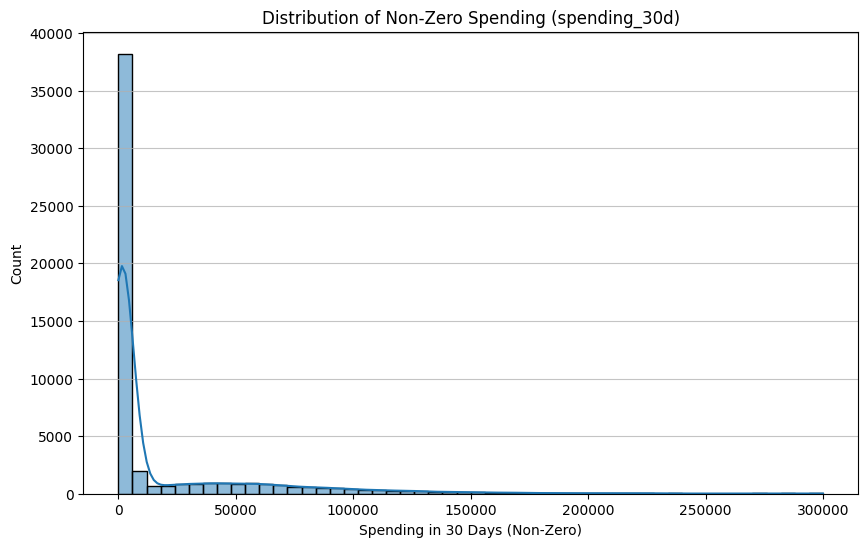

In [9]:
non_zero_spending_data = df_train[df_train['spending_30d'] > 0]['spending_30d']

plt.figure(figsize=(10, 6))
sns.histplot(non_zero_spending_data, bins=50, kde=True)
plt.title('Distribution of Non-Zero Spending (spending_30d)')
plt.xlabel('Spending in 30 Days (Non-Zero)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()

# 1. Feature Engineering

In [10]:
def engineer_features(df):
    df = df.copy()

    # Fill numeric NaNs with 0
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)

    # Ratios & Interactions
    df['avg_spend_per_transaction'] = df['historical_spending'] / (df['total_transactions'] + 1)
    df['playtime_per_week'] = df['sessions_per_week'] * (df['avg_session_length'] / 60)
    df['win_rate'] = df['competitive_rank'] / (df['games_played'] + 1)
    df['discount_sensitivity'] = df['purchases_on_discount'] / (df['total_transactions'] + 1)

    # Log Transforms for skewed features
    skewed_cols = ['friend_count', 'total_playtime_hours', 'historical_spending',
                   'total_transactions', 'daily_login_streak']
    for col in skewed_cols:
        if col in df.columns:
            df[f'log_{col}'] = np.log1p(df[col])

    return df

print("Loading and preparing data...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

features = [c for c in df_train.columns if c not in [ID_COL, TARGET] and df_train[c].dtype != 'object']
X = df_train[features]
y = df_train[TARGET]
y_bin = (y > 0).astype(int)
y_log = np.log1p(y)

Loading and preparing data...


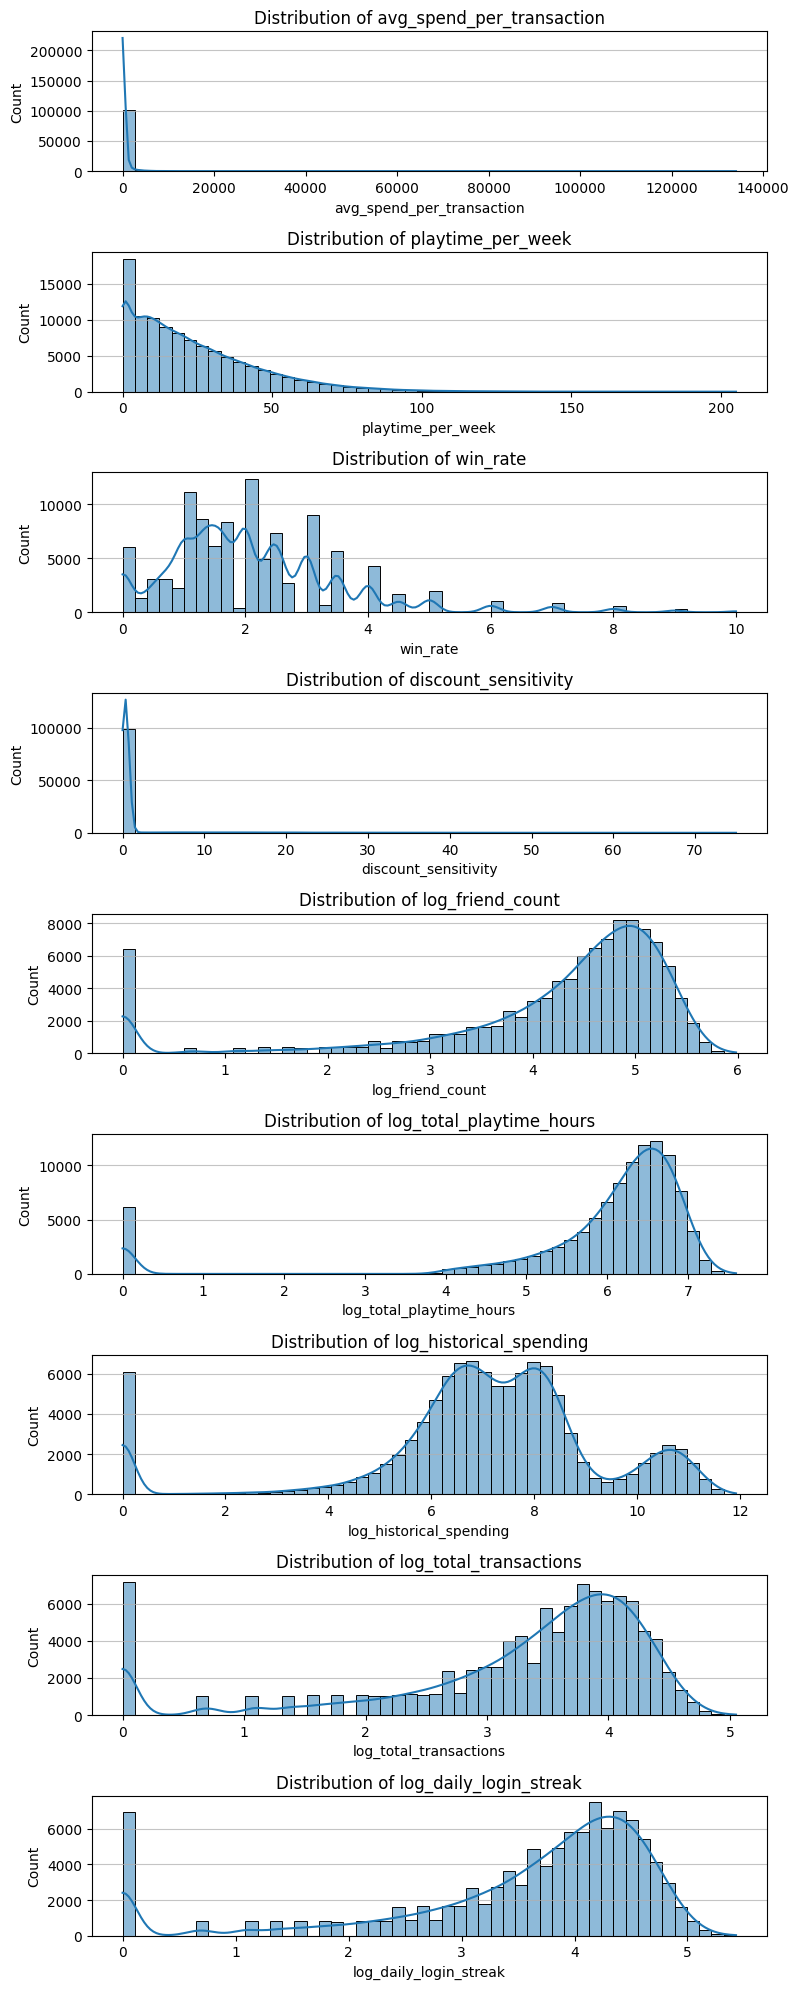

In [11]:
engineered_features = [
    'avg_spend_per_transaction', 'playtime_per_week', 'win_rate',
    'discount_sensitivity', 'log_friend_count', 'log_total_playtime_hours',
    'log_historical_spending', 'log_total_transactions', 'log_daily_login_streak'
]

plt.figure(figsize=(15, 20))
for i, feature in enumerate(engineered_features):
    plt.subplot(len(engineered_features), 2, 2*i + 1)
    sns.histplot(df_train[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

#  2. Optuna Tuning: Classifier (Will they spend?)

In [12]:
print(f"\n🔎 STARTING OPTUNA: Tuning Classifier ({OPTUNA_TRIALS} trials)...")

def objective_cls(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'scale_pos_weight': (y_bin == 0).sum() / (y_bin == 1).sum(),
        'tree_method': 'hist',
        'device': DEVICE,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': SEED,
        'n_jobs': -1
    }

    # Simple hold-out validation for speed during tuning
    X_tr, X_va, y_tr, y_va = train_test_split(X, y_bin, test_size=0.2, stratify=y_bin, random_state=SEED)

    model = xgb.XGBClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    return log_loss(y_va, model.predict_proba(X_va)[:, 1])

study_cls = optuna.create_study(direction='minimize')
study_cls.optimize(objective_cls, n_trials=OPTUNA_TRIALS)
best_cls_params = study_cls.best_params
best_cls_params['tree_method'] = 'hist'
best_cls_params['device'] = DEVICE
best_cls_params['scale_pos_weight'] = (y_bin == 0).sum() / (y_bin == 1).sum() # Re-add constant
print("Best Classifier Params:", best_cls_params)

[I 2025-11-23 16:17:32,672] A new study created in memory with name: no-name-25b50d62-9fbc-4997-a223-b66163de67a5



🔎 STARTING OPTUNA: Tuning Classifier (100 trials)...


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [16:17:36] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-11-23 16:17:36,866] Trial 0 finished with value: 0.5612509016282196 and parameters: {'n_estimators': 754, 'learning_rate': 0.02448561702796239, 'max_depth': 6, 'subsample': 0.7390118418726446, 'colsample_bytree': 0.7573803777035637, 'reg_alpha': 0.0013497028008512954, 'reg_lambda': 0.04030445018460043}. Best is trial 0 with value: 0.5612509016282196.
[I 2025-11-23 16:17:47,169] Trial 1 finished with value: 0.6389744785964873 and parameters: {'

Best Classifier Params: {'n_estimators': 451, 'learning_rate': 0.011076234251641002, 'max_depth': 5, 'subsample': 0.8825156164940813, 'colsample_bytree': 0.8231094138845289, 'reg_alpha': 0.30474769174552785, 'reg_lambda': 0.0039594752666842386, 'tree_method': 'hist', 'device': 'cuda', 'scale_pos_weight': np.float64(0.9306452810573995)}


#3. Optuna Tuning: Regressor (How much will they spend?)

In [13]:
print(f"\nSTARTING OPTUNA: Tuning Regressor ({OPTUNA_TRIALS} trials)...")

# Only tune on people who actually spent money!
mask_spend = y_bin == 1
X_spend = X[mask_spend]
y_spend_log = y_log[mask_spend]

def objective_reg(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'tree_method': 'hist',
        'device': DEVICE,
        'objective': 'reg:squarederror',
        'random_state': SEED,
        'n_jobs': -1
    }

    X_tr, X_va, y_tr, y_va = train_test_split(X_spend, y_spend_log, test_size=0.2, random_state=SEED)

    model = xgb.XGBRegressor(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

    preds = model.predict(X_va)
    # Optimize for MAE on the log scale (proxy for NMAE)
    return mean_absolute_error(y_va, preds)

study_reg = optuna.create_study(direction='minimize')
study_reg.optimize(objective_reg, n_trials=OPTUNA_TRIALS)
best_reg_params = study_reg.best_params
best_reg_params['tree_method'] = 'hist'
best_reg_params['device'] = DEVICE
print("Best Regressor Params:", best_reg_params)

[I 2025-11-23 16:21:34,089] A new study created in memory with name: no-name-fb5d871d-4b21-4b70-9595-45ab1b1e9735



STARTING OPTUNA: Tuning Regressor (100 trials)...


[I 2025-11-23 16:21:37,058] Trial 0 finished with value: 0.1592145930475208 and parameters: {'n_estimators': 395, 'learning_rate': 0.010966328328106593, 'max_depth': 8, 'subsample': 0.6891618162525492, 'colsample_bytree': 0.8719298802053497, 'reg_alpha': 0.04668434456863111, 'reg_lambda': 1.6844295763149255}. Best is trial 0 with value: 0.1592145930475208.
[I 2025-11-23 16:21:39,032] Trial 1 finished with value: 0.150925976794863 and parameters: {'n_estimators': 713, 'learning_rate': 0.07311267902011737, 'max_depth': 5, 'subsample': 0.7414319752068841, 'colsample_bytree': 0.800006765928227, 'reg_alpha': 0.5444967544263928, 'reg_lambda': 0.026468895320680582}. Best is trial 1 with value: 0.150925976794863.
[I 2025-11-23 16:21:42,891] Trial 2 finished with value: 0.1522410095215955 and parameters: {'n_estimators': 545, 'learning_rate': 0.06366963684745403, 'max_depth': 8, 'subsample': 0.7541635876623788, 'colsample_bytree': 0.7464749122651089, 'reg_alpha': 0.006821613341814601, 'reg_lamb

Best Regressor Params: {'n_estimators': 417, 'learning_rate': 0.025430388901937776, 'max_depth': 8, 'subsample': 0.6738327663207837, 'colsample_bytree': 0.8056204251176147, 'reg_alpha': 0.8891550438130729, 'reg_lambda': 0.0031662375191091998, 'tree_method': 'hist', 'device': 'cuda'}


# 4. Final Stratified K-Fold Training (Using Best Params)

In [14]:
print(f"\nSTARTING FINAL TRAINING ({N_FOLDS} Folds)...")

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

oof_probs = np.zeros(len(df_train))
oof_preds = np.zeros(len(df_train))
test_probs = np.zeros(len(df_test))
test_preds = np.zeros(len(df_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_bin)):
    # Data Split
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr_bin, y_val_bin = y_bin.iloc[train_idx], y_bin.iloc[val_idx]
    y_tr_log = y_log.iloc[train_idx]

    # 1. Train Classifier (Best Params)
    clf = xgb.XGBClassifier(**best_cls_params)
    clf.fit(X_tr, y_tr_bin, eval_set=[(X_val, y_val_bin)], verbose=False)

    oof_probs[val_idx] = clf.predict_proba(X_val)[:, 1]
    test_probs += clf.predict_proba(df_test[features])[:, 1] / N_FOLDS

    # 2. Train Regressor (Best Params - Spenders Only)
    mask = y_tr_bin == 1
    reg = xgb.XGBRegressor(**best_reg_params)
    reg.fit(X_tr[mask], y_tr_log[mask], verbose=False)

    oof_preds[val_idx] = np.expm1(reg.predict(X_val))
    test_preds += np.expm1(reg.predict(df_test[features])) / N_FOLDS

    print(f"  > Fold {fold+1} complete.")


STARTING FINAL TRAINING (5 Folds)...
  > Fold 1 complete.
  > Fold 2 complete.
  > Fold 3 complete.
  > Fold 4 complete.
  > Fold 5 complete.


# 5. Threshold Optimization

In [15]:
def nmae_scorer(threshold):
    # Hybrid prediction: If Prob > Threshold, use Regressor Amount, else 0
    final_pred = np.where(oof_probs > threshold, oof_preds, 0)
    return mean_absolute_error(y, final_pred) / np.mean(y)

# Find exact best threshold
res = minimize_scalar(nmae_scorer, bounds=(0.1, 0.9), method='bounded')
best_thresh = res.x
best_score = res.fun

print("="*40)
print(f"FINAL OPTIMIZED RESULTS")
print(f"Best Threshold: {best_thresh:.4f}")
print(f"Best OOF NMAE:  {best_score:.5f}")
print("="*40)

FINAL OPTIMIZED RESULTS
Best Threshold: 0.4773
Best OOF NMAE:  0.27424


##Generate Submission

In [16]:
final_test_prediction = np.where(test_probs > best_thresh, test_preds, 0)
final_test_prediction = np.clip(final_test_prediction, 0, None)

sub = pd.DataFrame({'id': df_test[ID_COL], 'spending_30d': final_test_prediction})
sub.to_csv("submission_optuna.csv", index=False)
print("🎉 Saved to submission_optuna.csv")

🎉 Saved to submission_optuna.csv
